In [1]:
import matplotlib.pyplot as plt
import math
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import trange

from utils.distributions import SumOfGaussians
from utils.plotting_utils import create_3d_hist, create_3d_hist_flat
from score_based_sampling.score_nets import get_medium_non_timestep_aware, get_medium_timestep_aware, get_large_timestep_aware
#define our distribution

gpu_id = 0
device = torch.device(f'cuda:{gpu_id}')

mean0 = torch.FloatTensor([2, 2])
mean1 = torch.FloatTensor([-1, 1])
d = len(mean0)

covar0 = torch.FloatTensor([[2, 0], [0, 1]])
covar1 = torch.FloatTensor([[0.5, 0.0], [0, 3]])

mixing_parameter = 0.4
sog_dis = SumOfGaussians([mean0, mean1], [covar0, covar1], [mixing_parameter, 1.0 - mixing_parameter])


In [2]:
N_train = 500_000
train_samples = sog_dis.sample(N_train)

N_val = 10_000
val_samples = sog_dis.sample(N_val)

train_bs = 1024
val_bs = 4096

class SamplesDataset(Dataset):
    def __init__(self, samples):
        super().__init__()
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        return self.samples[i]

train_dataset = SamplesDataset(train_samples)
val_dataset = SamplesDataset(val_samples)

train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=val_bs)

In [14]:
#Noise scales
#https://arxiv.org/pdf/2006.09011.pdf
#Technique 1
N_dist_estimation_samples = min(N_train, 10_000)
dist_estimation_samples = train_samples[:N_dist_estimation_samples]

#https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065
def pairwise_distances(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y = x
        y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist

D_mat = pairwise_distances(dist_estimation_samples)
max_D = torch.max(D_mat.view(-1))

#max_sigma = max_D
max_sigma = 5
min_sigma = 0.001
N_noise_scales = 100

#geometric series gamma
gamma = (min_sigma / max_sigma)**(1/ (N_noise_scales-1))
sigmas = max_sigma * gamma ** (torch.arange(0, N_noise_scales))
sigmas = sigmas.to(device)

print(f'Max sigma {max_sigma:.3f} - Min Sigma {min_sigma:.3f} - Num scales {N_noise_scales} - Gamma {gamma:.3f}')

Max sigma 5.000 - Min Sigma 0.001 - Num scales 100 - Gamma 0.918


In [15]:
#load our model
epochs = 20
lr = 0.01
momentum = 0.9

model = get_large_timestep_aware(d,d)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


print('Starting score net training...')

for epoch in range(epochs):
    avg_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        noise_scale_idcs = torch.randint(0, N_noise_scales, (len(data),), dtype=torch.long, device=device)
        noise_sigmas = sigmas[noise_scale_idcs, None]

        perturbation = noise_sigmas * torch.randn_like(data)
        noisy_data = data + perturbation
        output = model(noisy_data, noise_sigmas.squeeze(dim=1))

        loss_expanded = torch.sum( (noise_sigmas*output + perturbation / noise_sigmas) ** 2 , dim=1)
        loss = torch.mean(loss_expanded, dim=0)
        avg_loss += loss / len(train_loader)
        loss.backward()

        optimizer.step()

    print(f'Epoch {epoch} - Avg loss {avg_loss}')
    scheduler.step()

print('Training done')

Starting score net training...
Epoch 0 - Avg loss 1.742013931274414
Epoch 1 - Avg loss 1.7064173221588135
Epoch 2 - Avg loss 1.7007297277450562
Epoch 3 - Avg loss 1.7059811353683472
Epoch 4 - Avg loss 1.6983567476272583
Epoch 5 - Avg loss 1.6982390880584717
Epoch 6 - Avg loss 1.7015599012374878
Epoch 7 - Avg loss 1.6997102499008179
Epoch 8 - Avg loss 1.7010228633880615
Epoch 9 - Avg loss 1.6958268880844116
Epoch 10 - Avg loss 1.7016342878341675
Epoch 11 - Avg loss 1.6941890716552734
Epoch 12 - Avg loss 1.698232650756836
Epoch 13 - Avg loss 1.6940959692001343
Epoch 14 - Avg loss 1.6962558031082153
Epoch 15 - Avg loss 1.6997177600860596
Epoch 16 - Avg loss 1.6960657835006714
Epoch 17 - Avg loss 1.6948446035385132
Epoch 18 - Avg loss 1.694914698600769
Epoch 19 - Avg loss 1.693681240081787
Training done


100%|██████████| 20/20 [00:00<00:00, 53.08it/s]


Text(0.5, 1.0, 'Estimated scores')

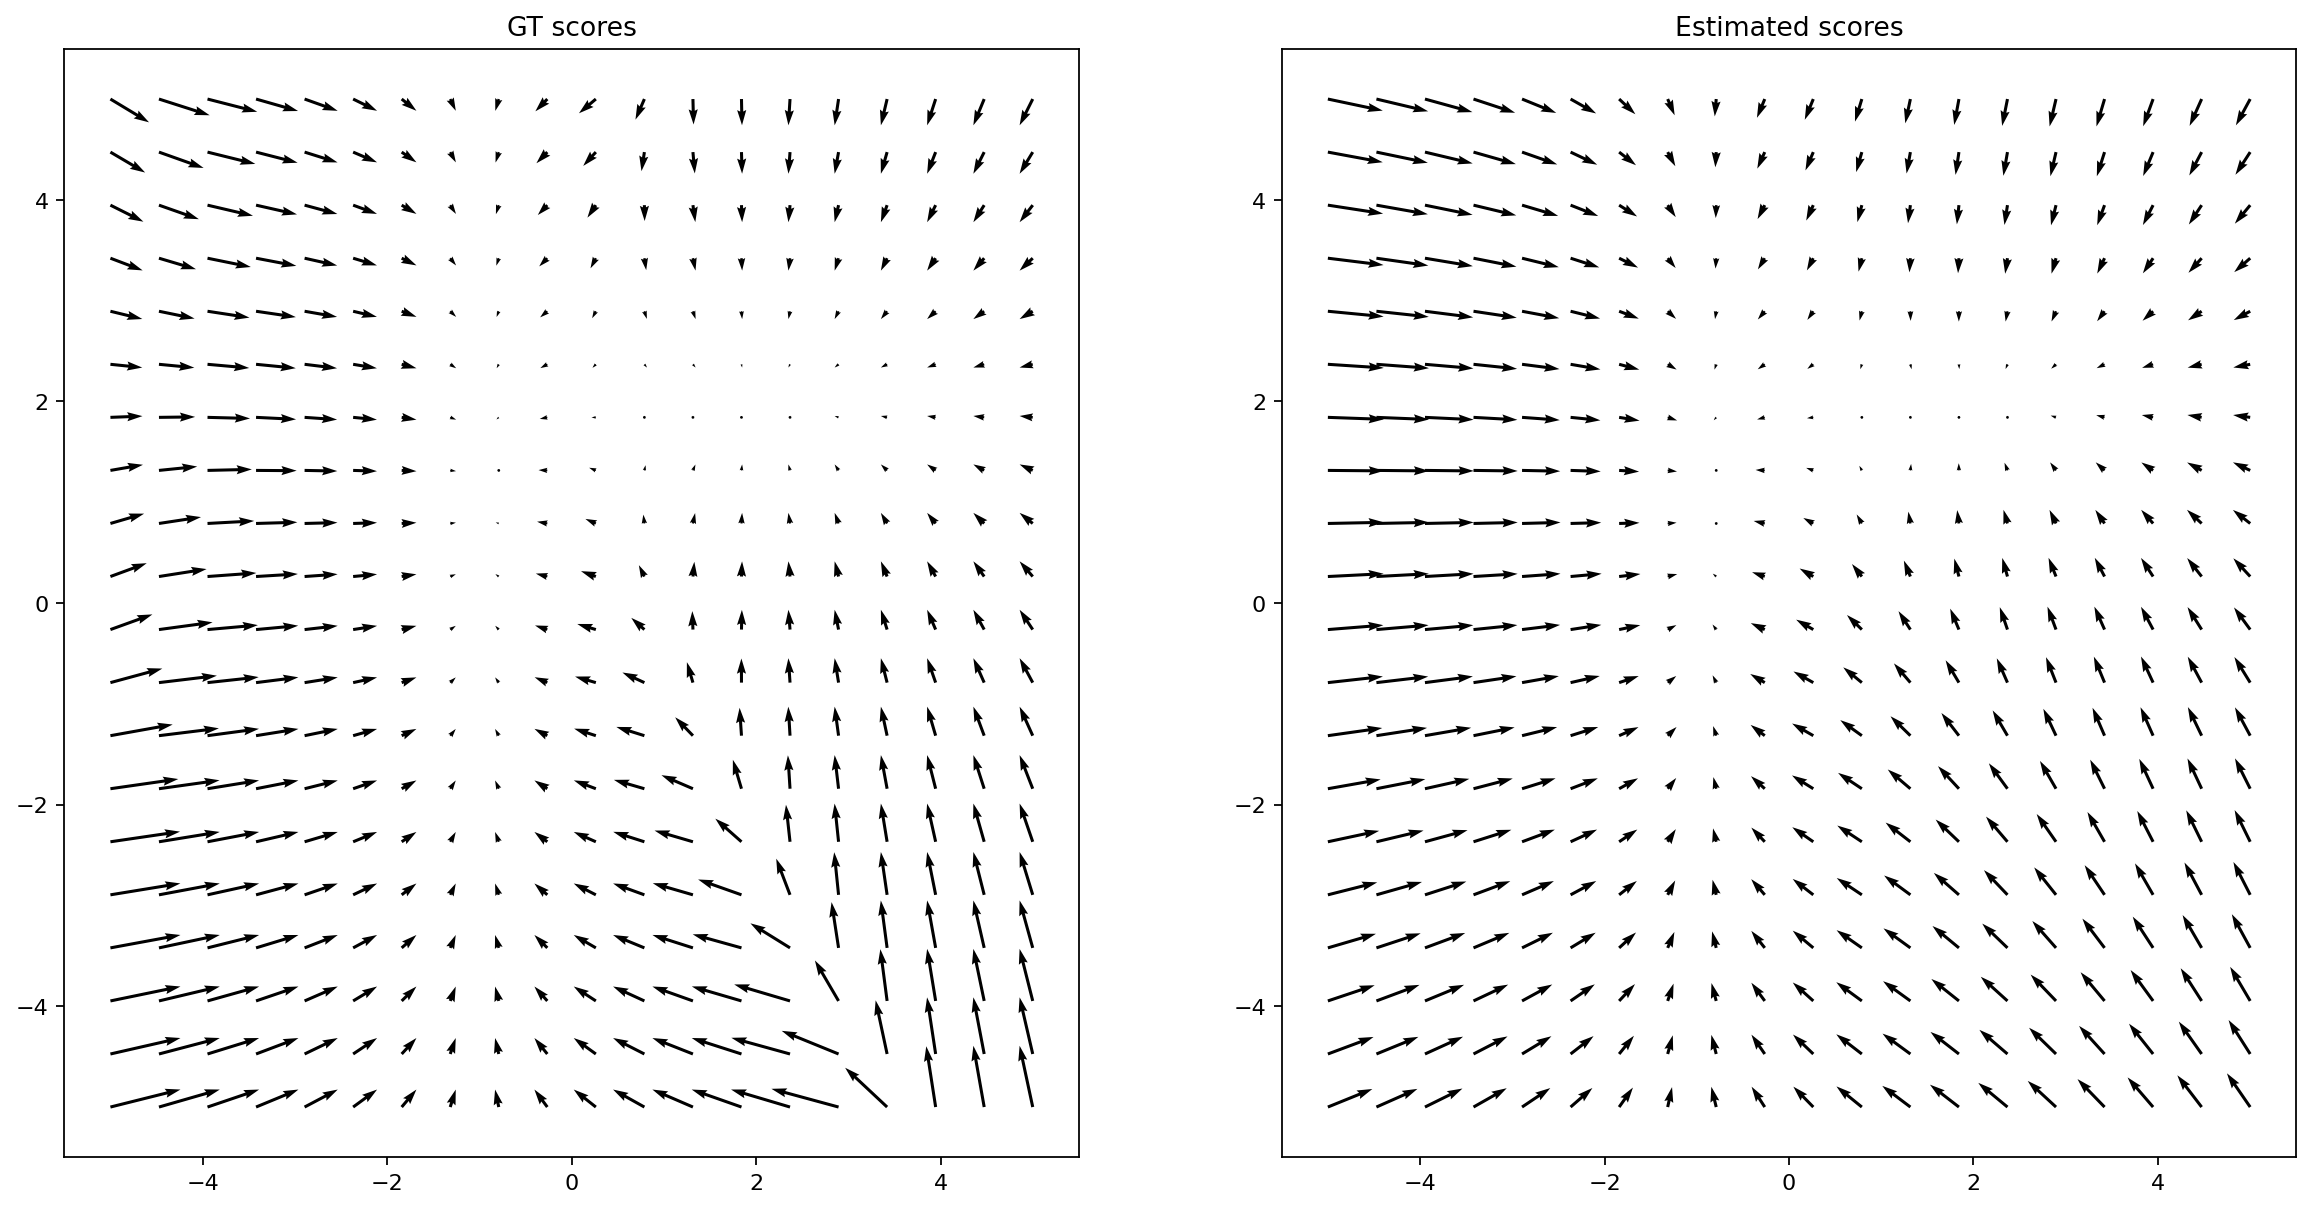

In [17]:
#compare vector fields
x_min = -5
x_max = 5
y_min = -5
y_max = 5
subdivs = 20

grid_x, grid_y = torch.meshgrid(torch.linspace(x_min, x_max,subdivs), torch.linspace(y_min, y_max,subdivs), indexing='ij')

gt_scores = torch.zeros((grid_x.shape[0], grid_x.shape[1], d))
learned_scores =  torch.zeros((grid_x.shape[0], grid_x.shape[1], d))

plot_scale = 99

for i in trange(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            xy = torch.FloatTensor([grid_x[i,j],grid_y[i,j]]).requires_grad_(True)
            with torch.enable_grad():
                log_prob = sog_dis.log_prob(xy)
                torch.sum(log_prob).backward()
                score = xy.grad.detach()
                gt_scores[i,j] = score.detach().cpu()

            with torch.no_grad():
                xy = xy[None,:].to(device)
                sigmas_batch = sigmas[plot_scale] * torch.ones(len(xy), device=device)
                learned_scores[i,j] = model(xy, sigmas_batch).detach().cpu()

#plot scores
fig = plt.figure(figsize=(18, 9), dpi=160)
ax = fig.add_subplot(121)
ax.quiver(grid_x, grid_y, gt_scores[:, :, 0], gt_scores[:, :, 1])
ax.set_title('GT scores')

ax = fig.add_subplot(122)
ax.quiver(grid_x, grid_y, learned_scores[:, :, 0], learned_scores[:, :, 1])
ax.set_title('Estimated scores')



In [16]:
#exact samples
num_samples = 500_000

gt_samples = sog_dis.sample(num_samples)

In [21]:
#Langevin samples
sampling_steps = 1_000
time_step = 1.0
sample_noise_scale = min_sigma

#https://abdulfatir.com/blog/2020/Langevin-Monte-Carlo/
#https://en.wikipedia.org/wiki/Stochastic_gradient_Langevin_dynamics
samples = 2 * torch.randn((num_samples, d), device=device)

with torch.no_grad():
    for k in trange(sampling_steps):
        sigmas_batch = sample_noise_scale * torch.ones(len(samples), device=device)
        score = model(samples, sigmas_batch)

        noise = torch.randn((num_samples,d), device=device)

        step_k = time_step * (0.5 + math.cos(math.pi * k / sampling_steps) / 2)
        samples = samples + step_k * score  + math.sqrt(2*step_k) * noise

samples = samples.detach().cpu()


100%|██████████| 1000/1000 [00:10<00:00, 92.98it/s]


Text(0.5, 1.0, 'Estimated density - Score Net Langevin Sample')

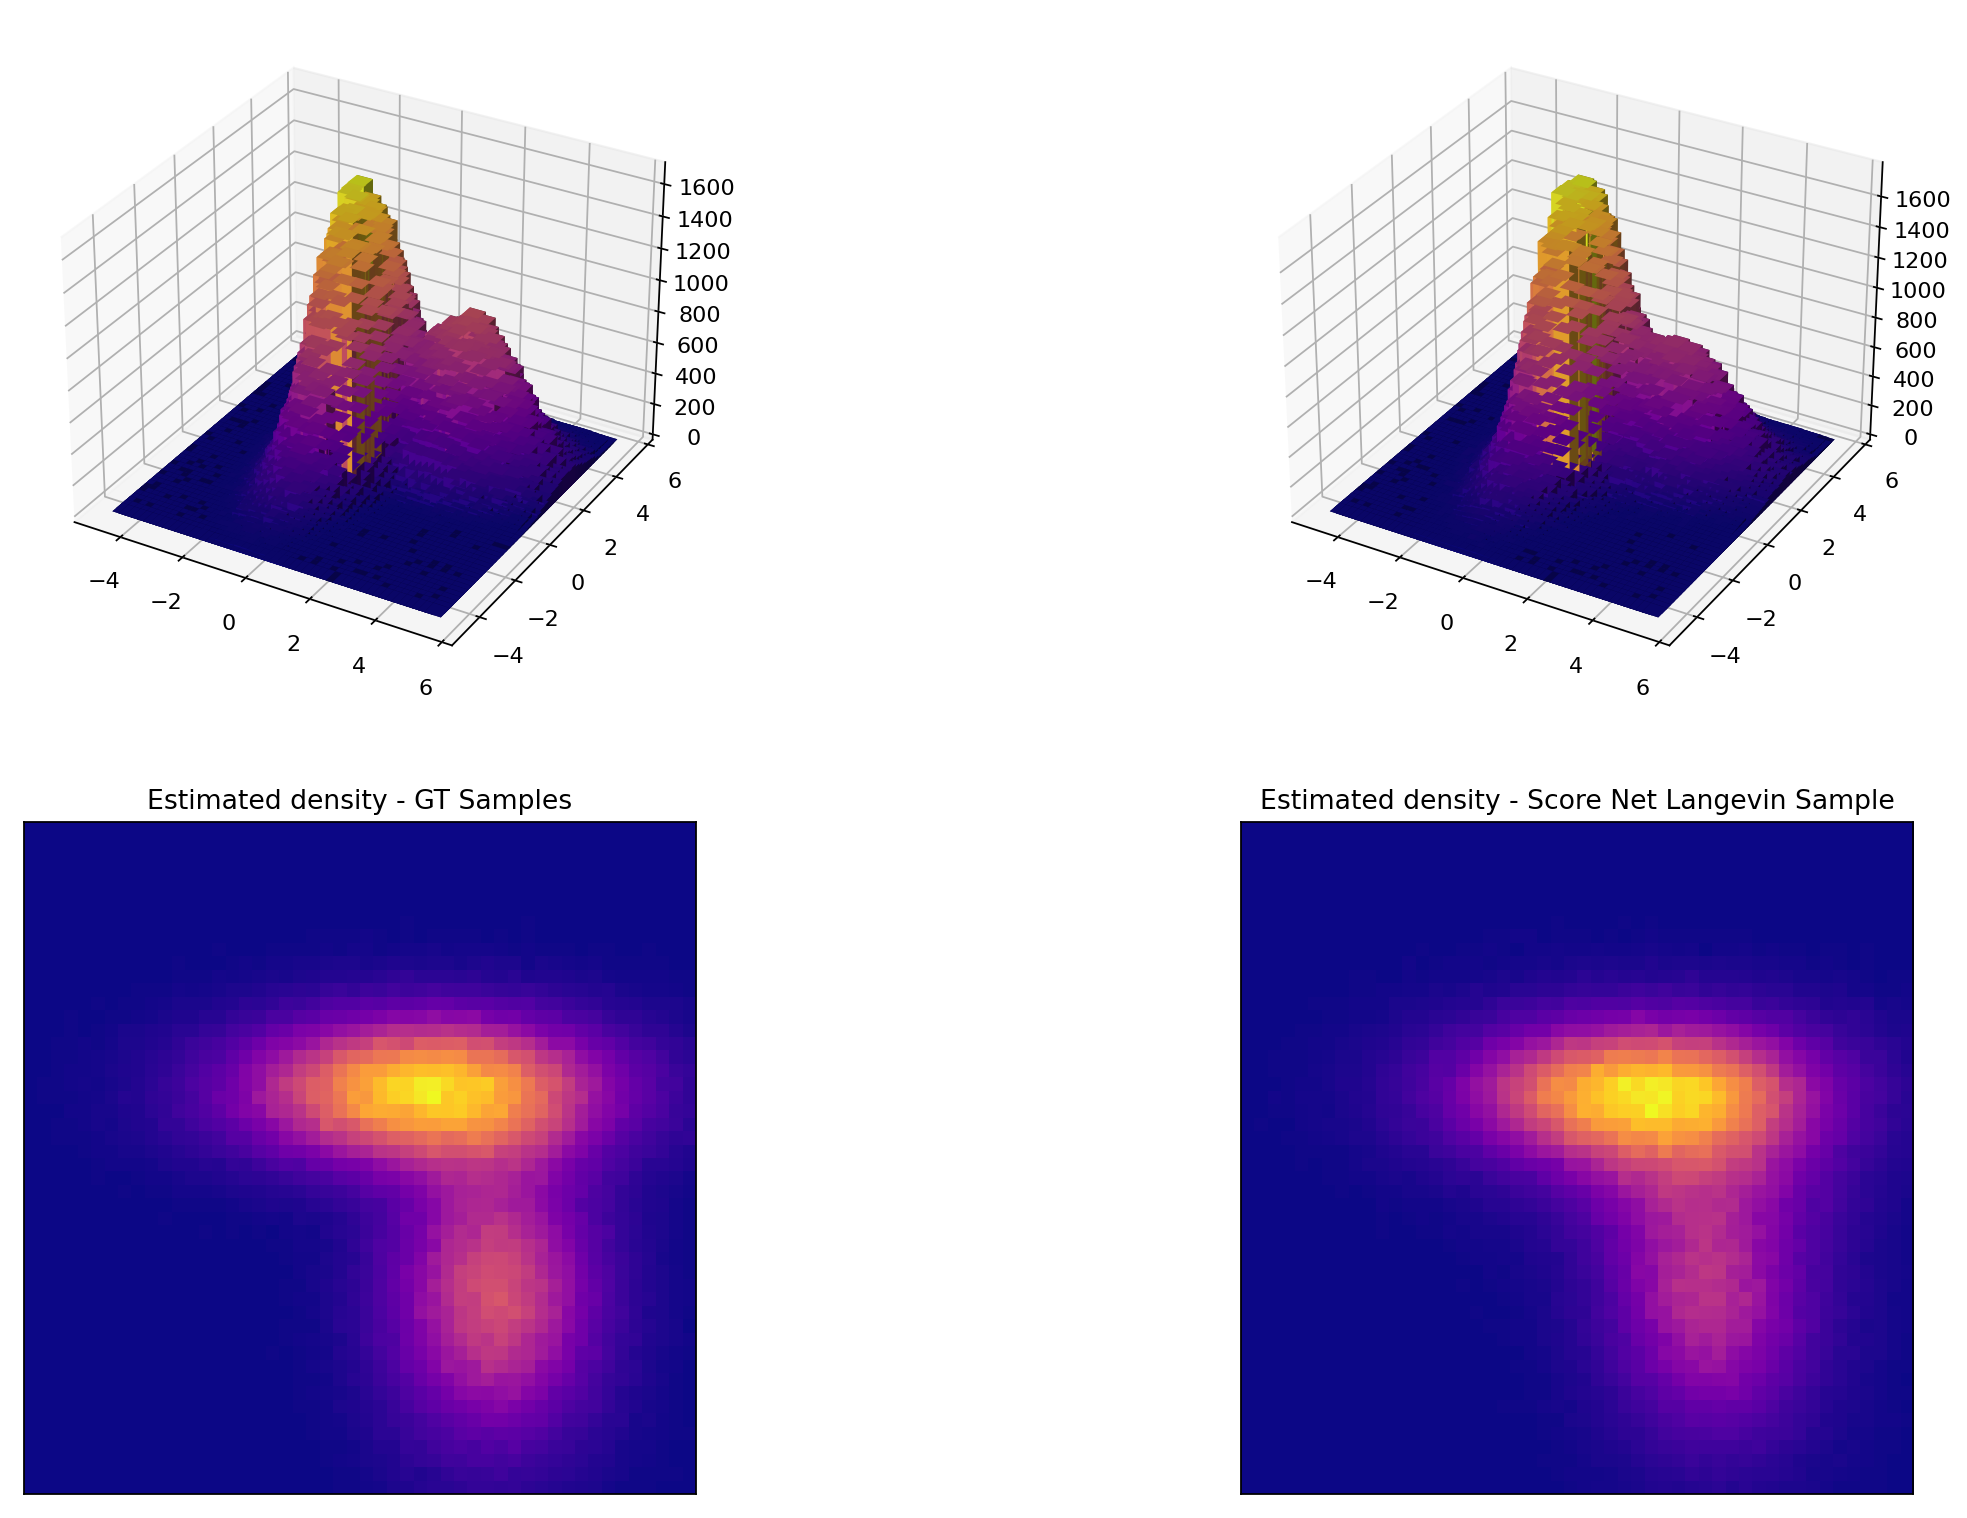

In [23]:
#visualize samples
fig = plt.figure(figsize=(18, 12), dpi=160)
ax = fig.add_subplot(221, projection='3d')
create_3d_hist(ax, gt_samples, x_min, x_max, y_min, y_max)

ax = fig.add_subplot(222, projection='3d')
create_3d_hist(ax, samples, x_min, x_max, y_min, y_max)

ax = fig.add_subplot(223)
create_3d_hist_flat(ax,  gt_samples, x_min, x_max, y_min, y_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Estimated density - GT Samples')

ax = fig.add_subplot(224)
create_3d_hist_flat(ax,  samples, x_min, x_max, y_min, y_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Estimated density - Score Net Langevin Sample')
